In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import os, time, shutil
from pathlib import Path
from glob import glob
import numpy as np
import spikeinterface.full as si
import matplotlib.pyplot as plt

In [7]:
plt.rcParams['figure.figsize'] = [15, 10]

In [8]:
file_path = "/net/bs-filesvr02/export/group/hierlemann/recordings/Maxtwo/nobenz/230427/How_old/M05562/AxonTracking/000004/"
file_name = "data.raw.h5"
full_path = os.path.join(file_path,file_name)
stream_name = "well001"

In [17]:
assert(os.path.exists(full_path))
rec_id = 0
common_el = list(range(27000))
while True:
    rec_name = 'rec' + '%0*d' % (4, rec_id)
    try:
        rec = si.MaxwellRecordingExtractor(full_path,stream_name=stream_name,rec_name=rec_name)
        rec_el = rec.get_property("contact_vector")["electrode"]
        common_el = list(set(common_el).intersection(rec_el))
        rec_id += 1
    except Exception:
        break
            

In [18]:
rec_list = []
for r in range(rec_id): #rec_id
    rec_name = 'rec' + '%0*d' % (4, r)
    rec = si.MaxwellRecordingExtractor(full_path,stream_name=stream_name,rec_name=rec_name)
    ch_id = rec.get_property("contact_vector")['device_channel_indices']
    rec_el = rec.get_property("contact_vector")["electrode"]
    
    chan_idx = [np.where(rec_el == el)[0][0] for el in common_el]
    sel_channels = rec.get_channel_ids()[chan_idx]
    rec_centered = si.highpass_filter(rec, 150)
    rec_list.append(rec_centered.channel_slice(sel_channels, renamed_channel_ids=list(range(len(chan_idx)))))

multirecording = si.concatenate_recordings(rec_list)

In [11]:
path_parts = file_path.split('/')
path_parts[0] = '/'
path_parts[6] = 'intermediate_data'
path_parts[8] = 'phornauer'
save_root = os.path.join(*path_parts[0:12], stream_name, 'sorted','sorter_output')
save_root

'/net/bs-filesvr02/export/group/hierlemann/intermediate_data/Maxtwo/phornauer/230427/How_old/M05562/well001/sorted/sorter_output'

In [12]:
sorting = si.KiloSortSortingExtractor(save_root)

In [19]:
multirecording

ConcatenateSegmentRecording: 268 channels - 10.0kHz - 1 segments - 19,207,000 samples 
                             1,920.70s (32.01 minutes) - int16 dtype - 9.59 GiB

In [27]:
sorting.register_recording(multirecording)

In [21]:
st = sorting.get_all_spike_trains()

In [28]:
sorting.get_total_duration()

1920.7

In [29]:
min_n_spikes = 100

ks_label = sorting.get_property('KSLabel')
n_spikes = [len(sorting.get_unit_spike_train(x)) for x in sorting.get_unit_ids()]

mua_idx = ks_label == 'mua'
bad_n_spikes_idx = np.array(n_spikes) < min_n_spikes
bad_idx = mua_idx | bad_n_spikes_idx
bad_id = [i for i, x in enumerate(bad_idx) if x]

cleaned_sorting = sorting.remove_units(bad_id)

print(f'Kept {cleaned_sorting.get_num_units()} out of {sorting.get_num_units()} units')

Kept 55 out of 419 units


In [141]:
redundant = si.find_redundant_units(cleaned_sorting)

In [142]:
redundant

[[166, 2], [217, 212], [307, 118], [318, 314], [408, 138], [410, 138]]

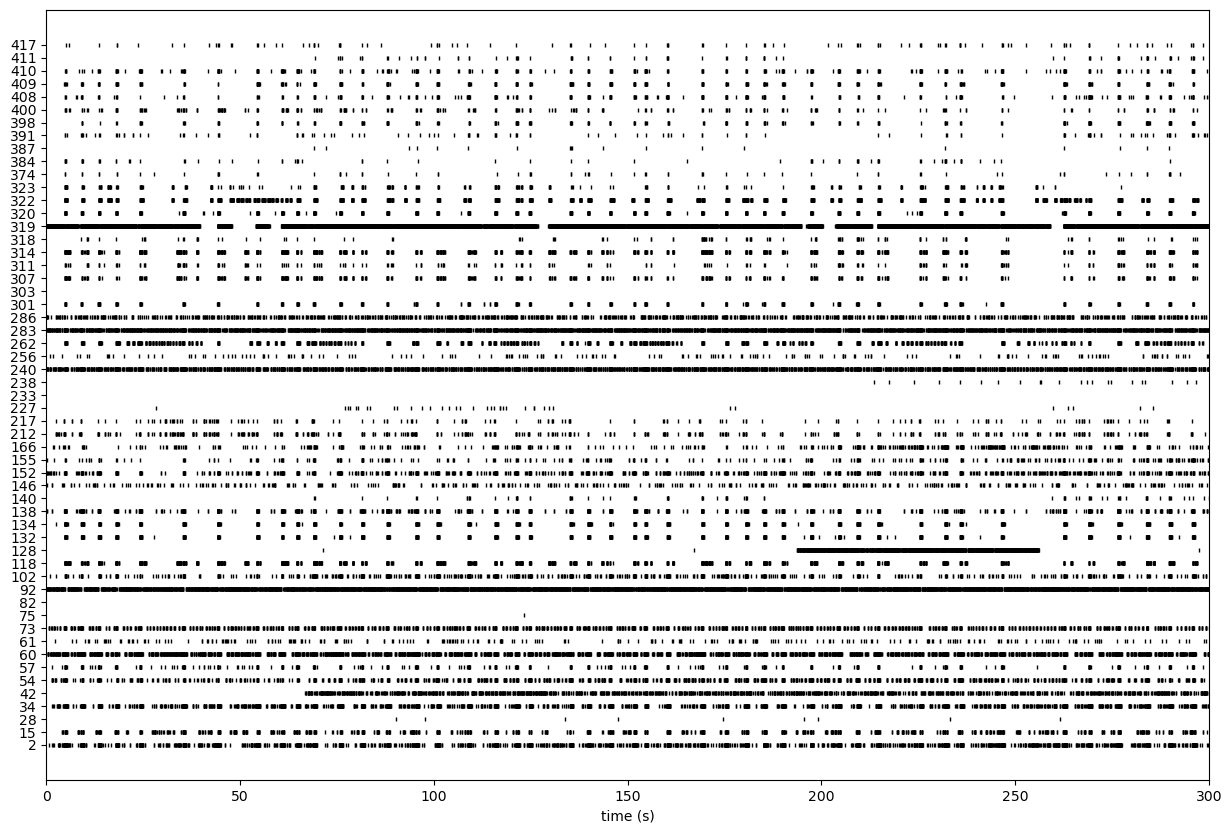

In [98]:
si.plot_rasters(cleaned_sorting, time_range = [0,300])

In [146]:
wf_folder = '/net/bs-filesvr02/export/group/hierlemann/intermediate_data/Maxtwo/phornauer/230427/How_old/M05562/well001/sorted/wf_full/'

In [149]:
we = si.WaveformExtractor.create(multirecording, cleaned_sorting, wf_folder + '1', 
                                 allow_unfiltered=True,
                                 remove_if_exists=True)
we.set_params(ms_before=2, ms_after=3)
we.run_extract_waveforms(n_jobs=-1)

extract waveforms memmap:   0%|          | 0/1921 [00:00<?, ?it/s]

In [150]:
metrics = si.compute_quality_metrics(we, n_jobs=-1)

/home/phornauer/Git/spikeinterface/src/spikeinterface/qualitymetrics/misc_metrics.py:216: RuntimeWarning: divide by zero encountered in true_divide
  snrs[unit_id] = np.abs(amplitude) / noise
/home/phornauer/Git/spikeinterface/src/spikeinterface/qualitymetrics/misc_metrics.py:551: UserWarning: Units [28, 75, 82, 233, 374, 384, 387] have too few spikes and amplitude_cutoff is set to NaN
  warnings.warn(f"Units {nan_units} have too few spikes and " "amplitude_cutoff is set to NaN")


In [151]:
metrics

,num_spikes,firing_rate,presence_ratio,snr,isi_violations_ratio,isi_violations_count,rp_contamination,rp_violations,sliding_rp_violation,amplitude_cutoff,amplitude_median
2,25063,13.048888,1.00000,inf,0.002038,2,0.001530,1,0.005,0.010017,1.0
15,9306,4.845109,1.00000,inf,0.000000,0,0.000000,0,0.010,0.003925,0.0
28,122,0.063519,0.93750,inf,0.000000,0,0.000000,0,NaN,NaN,1.0
34,16434,8.556256,1.00000,inf,1.332257,562,1.000000,561,0.220,0.018695,1.0
42,8149,4.242724,0.96875,inf,0.000000,0,0.000000,0,0.015,0.032874,0.0
54,3190,1.660853,0.87500,inf,0.062915,1,0.099304,1,0.050,0.176323,1.0
57,3743,1.948769,1.00000,inf,0.000000,0,0.000000,0,0.020,0.067458,1.0
60,21578,11.234446,1.00000,inf,0.184256,134,0.331245,134,0.045,0.004954,0.0
61,2343,1.219868,1.00000,inf,0.000000,0,0.000000,0,0.110,0.000539,1.0
73,11047,5.751549,1.00000,inf,0.000000,0,0.000000,0,0.005,0.001549,0.0


In [170]:
keep_mask = (metrics['snr'] > 10) & (metrics['isi_violations_ratio'] < 0.05) & (metrics['firing_rate'] > 1) & (metrics['presence_ratio'] > 0.95)
keep_unit_ids = keep_mask[keep_mask].index.values
keep_unit_ids

array([  2,  15,  42,  57,  61,  73,  92, 128, 146, 262, 283, 286, 301,
       318, 319])

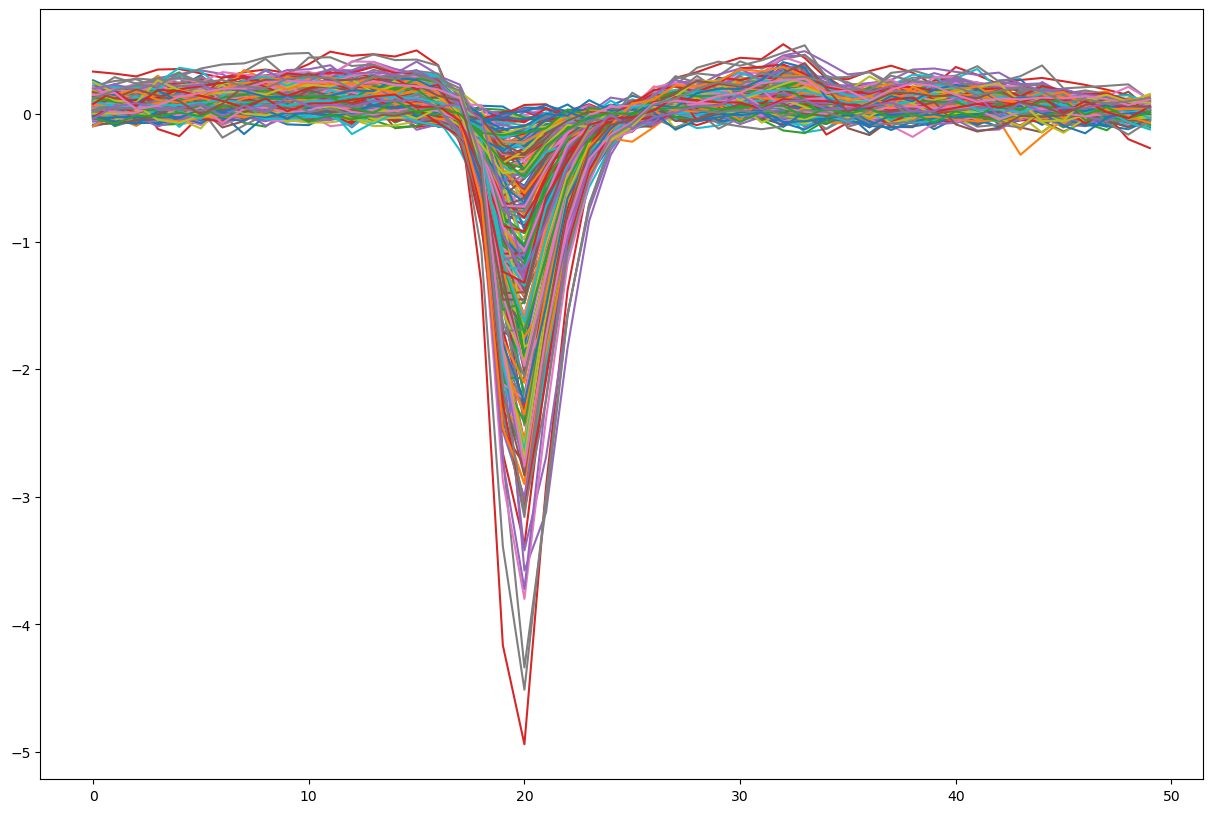

In [191]:
template = we.get_template(unit_id=319)
template_offset = template# - np.median(template,axis=0)
plt.plot(template_offset)
plt.show()

In [192]:
template.shape

(50, 268)

In [184]:
split_sorting = si.SplitSegmentSorting(cleaned_sorting, multirecording)

In [200]:
sel_idx = 10
rec_name = 'rec' + '%0*d' % (4, sel_idx)
rec = si.MaxwellRecordingExtractor(full_path,stream_name=stream_name,rec_name=rec_name)
rec_filt = si.highpass_filter(rec, 150)
ss = si.SelectSegmentSorting(split_sorting, sel_idx)
ss.register_recording(rec_filt)

In [201]:
seg_we = si.WaveformExtractor.create(rec_filt,ss,#rec_list[0],ss, 
                                 wf_folder + 'seg' + str(sel_idx), 
                                 allow_unfiltered=True,
                                 remove_if_exists=True)
seg_we.set_params(ms_before=2, ms_after=3)
seg_we.run_extract_waveforms(n_jobs=-1)

extract waveforms memmap:   0%|          | 0/61 [00:00<?, ?it/s]

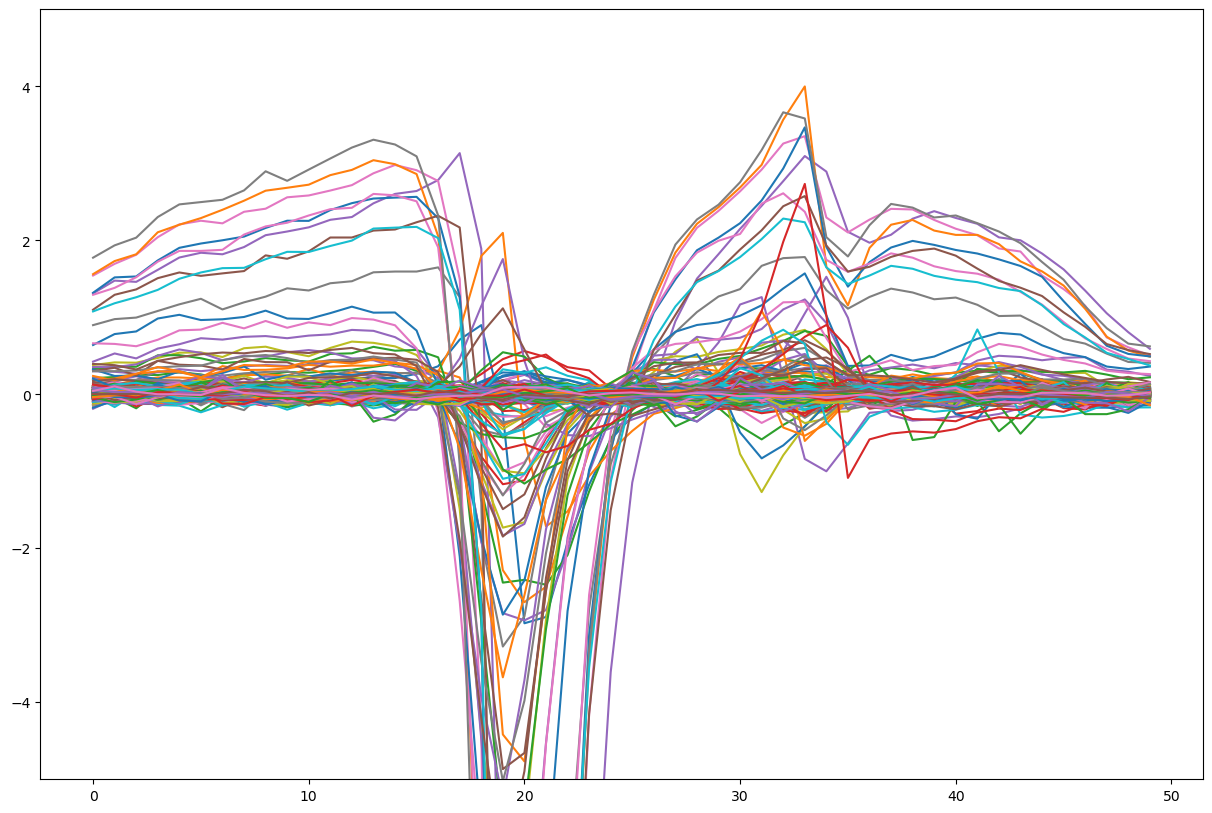

In [202]:
template = seg_we.get_template(unit_id=319)
template_offset = template# - np.median(template,axis=0)
plt.plot(template_offset)
plt.ylim(-5, )
plt.show()
